In [1]:
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

Get Technical Features

In [2]:
sp1500 = pd.read_excel("../data/SPR as of Feb 12 20251.xlsx")
tickers = sp1500['Ticker'].str.split(" ").str[0]

In [3]:
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Get the parent directory of the current working directory

# Construct the path to the `src` directory
src_path = os.path.join(project_root, "src")

# Add the `src` directory to the Python module search path
sys.path.append(src_path)


In [4]:
import importlib
from Features import technical_features

importlib.reload(technical_features)
from Features.technical_features import BuildFeatures

In [5]:
# Generate all NYSE trading days from 1980 to 2025
all_dates = pd.bdate_range(start="1980-01-01", end="2024-12-31", freq="B") 
date_to_qid = {date: qid for qid, date in enumerate(all_dates)}

In [6]:
import pickle as pkl
import gzip
from tqdm import tqdm

# Define storage path
cache_path = "../data/technical_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

# Process stock data
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    try:
        obj = BuildFeatures(tick)
    except:
        continue
    
    obj.build_technical_features()  # Compute technical indicators
    data = obj.technical_features.copy()
        
    if data.empty:
        continue

    # Convert data to monthly frequency by taking the last value of each month
    data = data.resample('BM').last()

    # Compute returns (convert to float32 to reduce storage size)
    data["Return"] = obj.stock["Close"].pct_change().shift(-1).astype(np.float32)

    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")


Processing Tickers: 100%|██████████| 90/90 [01:14<00:00,  1.21ticker/s]

✅ All data has been successfully stored and optimized with compression!


In [8]:
# Set cutoff dates for training, validation, and test sets
train_cutoff = "2015-01-01"
valid_cutoff = "2018-01-01"

# Paths
data_path = "../data/technical_features"

# List to store all data
all_data = []

# Process all tickers
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    
    file_path = os.path.join(data_path, f"{tick}.pkl.gz")
    try:
        with gzip.open(file_path, "rb") as f:
            data = pkl.load(f)
            data["Ticker"] = tick  # Add ticker label
            all_data.append(data)
    except:
        continue

# **Step 1: Merge all data and sort by date**
all_data = pd.concat(all_data).sort_index()

# Remove rows where 'Return' is NaN
all_data = all_data.dropna(subset=["Return"])

# Drop any remaining NaN values
all_data = all_data.dropna()

# **Step 2: Assign incremental `qid` values based on unique dates**
unique_dates = all_data.index.unique()
date_to_qid = {date: i for i, date in enumerate(unique_dates)}  # Incremental mapping
all_data["qid"] = all_data.index.map(date_to_qid).astype(np.int32)

# **Step 3: Compute quintile ranking for each day's stock returns**
def compute_ranked_labels(df):
    """ Assign quintile ranking to stock returns for each date """
    df["Ranked_Return"] = df.groupby("qid")["Return"].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates="drop")  # 0-4 ranking
    ).astype(np.int32)
    return df

all_data = compute_ranked_labels(all_data)

# **Step 4: Split dataset into train, validation, and test sets**
train_data = all_data[all_data.index < train_cutoff]
valid_data = all_data[(all_data.index >= train_cutoff) & (all_data.index < valid_cutoff)]
test_data = all_data[all_data.index >= valid_cutoff]

# **Step 5: Extract features and labels**
def extract_features_labels(df):
    """ Helper function to extract X, y, qid """
    X = df.drop(columns=["Return", "Ranked_Return", "qid", "Ticker"]).values
    y = df["Ranked_Return"].values
    qid = df["qid"].values
    return X, y, qid

X_train, y_train, qid_train = extract_features_labels(train_data)
X_valid, y_valid, qid_valid = extract_features_labels(valid_data)
X_test, y_test, qid_test = extract_features_labels(test_data)

# **Step 5: Save dataset in compressed format**
dataset = {
    "train": (X_train, y_train, qid_train),
    "valid": (X_valid, y_valid, qid_valid),
    "test": (X_test, y_test, qid_test),
}

Processing Tickers: 100%|██████████| 1506/1506 [00:02<00:00, 531.35ticker/s]


In [86]:
all_data

,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,Bollinger_Band_Upper,...,MidPoint_over_period,Midpoint_Price_over_period,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Return,Ticker,qid,Ranked_Return
date,,,,,,,,,,,,,,,,,,,,,
2001-10-31,36.09560000,44.08368750,59109091.38114960,-1272569.91654204,21.10572145,29.45404375,1.02416667,1.43215808,35.74500000,38.28328121,...,35.22000000,34.96500000,32.89000000,193,37.55000000,203,0.02771493,JPM,0,4
2001-10-31,47.73320000,48.48806500,298289573.27553105,7271845.40912002,22.61164515,22.77603565,0.98858974,1.05339156,48.02250000,49.81175126,...,46.86000000,46.75000000,44.28000000,196,49.44000000,202,0.01482874,KO,0,2
2001-10-31,12.97460000,13.46710000,35891284.12069868,342196.00425530,30.83212669,32.01063182,0.32230769,0.39994024,13.73750000,13.97391780,...,12.97000000,12.97500000,12.01000000,196,13.93000000,206,0.05455851,ADM,0,4
2001-10-31,58.44640000,56.48647500,126824237.93700591,-1371303.36473349,12.55584523,17.48079660,1.32371795,1.88295967,59.47750000,61.35767936,...,56.90000000,56.73000000,53.01000000,193,60.79000000,202,0.01627395,BAC,0,2
2001-10-31,7.10237200,7.82506400,4867003.68321890,45844.00838223,33.52602003,40.51105410,0.03980385,0.26538156,5.97690000,6.18455471,...,6.15855000,6.15855000,5.78960000,194,6.52750000,199,0.00375163,CNH,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,90.53000000,87.53810000,59923857.32254740,335853.85400479,25.11800560,23.90287621,4.17923077,2.26804980,98.22500000,98.73344679,...,93.59500000,93.72000000,89.31000000,6006,97.88000000,6014,0.00718612,FSS,270,3
2024-11-29,248.74160000,225.42440000,283950939.09577757,177168.27088511,27.16295409,25.15500748,5.37442308,4.62889313,267.53250000,268.16520989,...,261.59000000,261.75750000,256.52000000,6005,266.66000000,6014,-0.00950985,TRV,270,1
2024-11-29,279.30900000,246.09715000,1212476738.24073863,2270622.10433769,31.15669517,25.41463864,8.90846154,5.52206418,306.09750000,307.24040484,...,295.55500000,294.56500000,285.54000000,6007,305.57000000,6013,-0.00794276,AXP,270,1


In [9]:
import xgboost as xgb

# Load dataset
(train, valid, test) = (dataset['train'], dataset['valid'], dataset['test'])

# Unpack dataset
X_train, y_train, qid_train = train
X_valid, y_valid, qid_valid = valid
X_test, y_test, qid_test = test

# Initialize XGBoost Ranker with appropriate parameters
ranker = xgb.XGBRanker(
    tree_method="hist",  # Use "gpu_hist" if GPU acceleration is available
    device="cpu",
    lambdarank_pair_method="topk",
    lambdarank_num_pair_per_sample=13,
    eval_metric=["ndcg@1", "ndcg@5"],  
    num_boost_round=1000,
    early_stopping_rounds=50  # Stop training if no improvement for 50 rounds
)

# Train the model
ranker.fit(
    X_train,
    y_train,
    qid=qid_train,
    eval_set=[(X_valid, y_valid)],
    eval_qid=[qid_valid],
    verbose=True,
)

# Retrieve evaluation results
test_eval = ranker.evals_result()
print("✅ Training Completed.")

# Predict on the test set
y_pred = ranker.predict(X_test)

# Create a DataFrame to store predictions
predictions = pd.DataFrame({
    "qid": qid_test,
    "y_true": y_test,
    "y_pred": y_pred
}).sort_values(by="qid")

# Display the first 20 predictions
print(predictions.head(20))

[0]	validation_0-ndcg@1:0.48519	validation_0-ndcg@5:0.45503
[1]	validation_0-ndcg@1:0.54444	validation_0-ndcg@5:0.45751
[2]	validation_0-ndcg@1:0.48704	validation_0-ndcg@5:0.48708
[3]	validation_0-ndcg@1:0.62222	validation_0-ndcg@5:0.51490
[4]	validation_0-ndcg@1:0.56852	validation_0-ndcg@5:0.51191
[5]	validation_0-ndcg@1:0.43704	validation_0-ndcg@5:0.52252
[6]	validation_0-ndcg@1:0.51111	validation_0-ndcg@5:0.55524
[7]	validation_0-ndcg@1:0.52222	validation_0-ndcg@5:0.51931
[8]	validation_0-ndcg@1:0.50926	validation_0-ndcg@5:0.52011
[9]	validation_0-ndcg@1:0.50926	validation_0-ndcg@5:0.50922
[10]	validation_0-ndcg@1:0.46481	validation_0-ndcg@5:0.48823
[11]	validation_0-ndcg@1:0.42037	validation_0-ndcg@5:0.49377
[12]	validation_0-ndcg@1:0.45000	validation_0-ndcg@5:0.48440
[13]	validation_0-ndcg@1:0.47593	validation_0-ndcg@5:0.50376
[14]	validation_0-ndcg@1:0.45370	validation_0-ndcg@5:0.50545
[15]	validation_0-ndcg@1:0.46296	validation_0-ndcg@5:0.50067
[16]	validation_0-ndcg@1:0.45741	v

In [15]:
test_data_selected = test_data.reset_index()[["date", "qid", "Ticker", "Return"]]
predictions['return_true'] = test_data_selected['Return']
predictions["date"] = test_data_selected['date']

In [16]:
predictions

,qid,y_true,y_pred,return_true,date
0,439,2,-0.43201998,0.00229621,2018-01-31
908,439,2,0.01882025,0.00331675,2018-01-31
907,439,0,-0.22434658,-0.01818462,2018-01-31
906,439,4,-0.18168747,0.02622995,2018-01-31
905,439,0,-0.54578543,-0.01956425,2018-01-31
...,...,...,...,...,...
113886,518,3,-0.39349243,0.01155198,2024-11-29
113885,518,2,-0.17610127,-0.00228262,2024-11-29
113884,518,1,-0.27358460,-0.00487260,2024-11-29
113893,518,0,-0.24552833,-0.01368653,2024-11-29


In [41]:
test_data

,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,Bollinger_Band_Upper,...,MidPoint_over_period,Midpoint_Price_over_period,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Return,Ticker,qid,Ranked_Return
date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,79.04280000,83.35365000,146198610.13070935,-2197004.38338554,14.17699836,14.82908473,0.83724359,1.15314628,78.43500000,79.96216175,...,78.70000000,78.63500000,77.13000000,1338.00000000,80.27000000,1345.00000000,0.00229621,KHC,439,2
2018-01-31,6.06560000,6.23585000,93978622.07251799,1038744.37338480,36.93774369,26.77490848,0.26756410,0.18964787,6.57500000,6.75940285,...,6.42000000,6.33030000,6.17000000,7098.00000000,6.67000000,7109.00000000,-0.00614439,LSCC,439,1
2018-01-31,32.68220000,32.80537500,14200027.12074200,-1225.44797964,28.16754249,24.08318139,1.46160256,0.85572741,35.19500000,35.88299538,...,33.67500000,33.23500000,31.96000000,2777.00000000,35.39000000,2789.00000000,0.01522989,LMAT,439,4
2018-01-31,13.11180000,10.98155000,-291700543.97313130,-1963967.72172469,18.27890915,14.65512235,0.55916667,0.57395569,15.16250000,15.55416118,...,13.93500000,14.12500000,12.79000000,4723.00000000,15.08000000,4733.00000000,-0.01397206,EXTR,439,0
2018-01-31,7.07453600,6.77620100,4065171.56933465,-14051.89076059,18.02777661,23.55783418,-0.17043526,0.30565103,6.78835000,7.20841272,...,7.26330000,7.28330000,6.75330000,1266.00000000,7.77330000,1253.00000000,0.02468423,VTOL,439,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,59.13780000,55.81450000,183156385.10849434,5528889.80463064,21.66119286,22.24725916,-0.21576923,1.55953521,61.97250000,64.62046661,...,59.67000000,59.69000000,55.21000000,1380.00000000,64.13000000,1386.00000000,-0.00016067,CTVA,518,2
2024-11-29,59.39500000,67.40075000,56929580.08322994,415928.84139682,27.78389282,32.18139503,-0.73653846,1.67411552,54.74000000,55.60536915,...,53.12500000,53.18000000,50.97000000,5304.00000000,55.28000000,5307.00000000,0.04178120,CRI,518,4
2024-11-29,23.44100000,29.87310000,8106612727.08013153,-20429915.83337688,12.33487453,15.39784496,0.43608974,0.93283779,23.91250000,25.06472350,...,24.35000000,24.67315000,23.65000000,10096.00000000,25.05000000,10084.00000000,-0.00498960,INTC,518,1


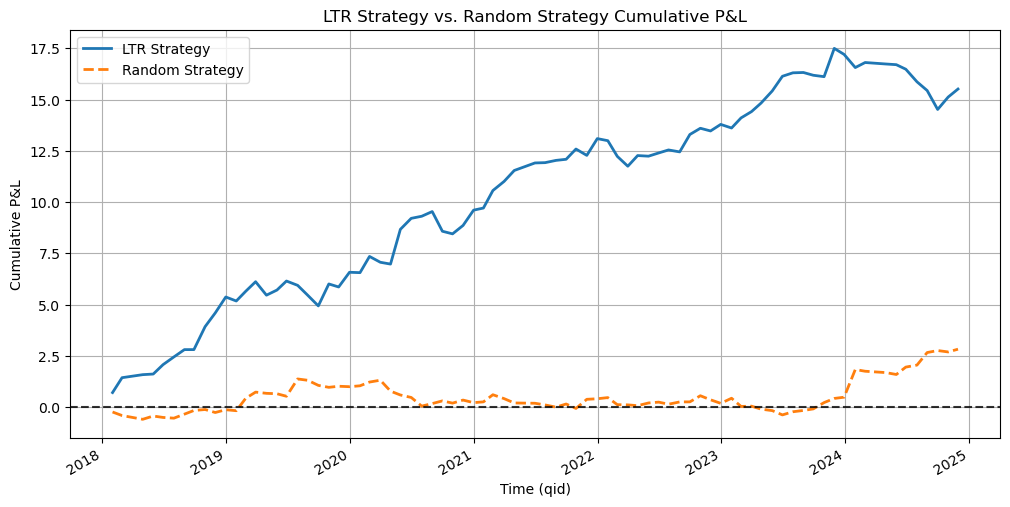

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set parameters
top_k = 50
position_size = 1
risk_free_rate = 0.00

# Copy predictions DataFrame
df = predictions.copy()

# **Sort by `qid` (to maintain chronological order)**
df = df.sort_values(by=["qid"])

# **LTR Strategy**
# Step 1: Sort stocks by predicted return `y_pred` within each `qid`
df["rank"] = df.groupby("qid")["y_pred"].rank(ascending=False, method="first")

# Step 2: Select long and short positions
df["long"] = (df["rank"] <= top_k).astype(int)
df["short"] = (df["rank"] > (df.groupby("qid")["rank"].transform("max") - top_k)).astype(int)

# Step 3: Compute returns
df["long_return"] = df["long"] * df["return_true"]
df["short_return"] = -df["short"] * df["return_true"]  # Short positions are negative

# Step 4: Compute daily strategy returns
df["ltr_strategy_return"] = position_size * (df["long_return"] + df["short_return"])

# **Random Strategy**
df["random_long"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))
df["random_short"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))

df["random_long_return"] = df["random_long"] * df["return_true"]
df["random_short_return"] = -df["random_short"] * df["return_true"]

df["random_strategy_return"] = position_size * (df["random_long_return"] + df["random_short_return"])

# **Compute cumulative returns**
monthly_pnl_ltr = df.groupby("date")["ltr_strategy_return"].sum()
monthly_pnl_random = df.groupby("date")["random_strategy_return"].sum()

cumulative_pnl_ltr = monthly_pnl_ltr.cumsum()
cumulative_pnl_random = monthly_pnl_random.cumsum()

# **Compute performance metrics**
def compute_metrics(monthly_pnl, label):
    mean_return = monthly_pnl.mean() * 12  # Annualized return
    std_dev = monthly_pnl.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return {
        "Strategy": label,
        "Annualized Return": mean_return,
        "Annualized Volatility": std_dev,
        "Sharpe Ratio": sharpe_ratio
    }

ltr_metrics = compute_metrics(monthly_pnl_ltr, "LTR Strategy")
random_metrics = compute_metrics(monthly_pnl_random, "Random Strategy")

performance_df = pd.DataFrame([ltr_metrics, random_metrics])

# **Plot cumulative returns**
plt.figure(figsize=(12, 6))
cumulative_pnl_ltr.plot(label="LTR Strategy", linewidth=2)
cumulative_pnl_random.plot(label="Random Strategy", linewidth=2, linestyle="dashed")

plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (qid)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy vs. Random Strategy Cumulative P&L")
plt.legend()
plt.grid()
plt.show()


In [53]:
performance_df

,Strategy,Annualized Return,Annualized Volatility,Sharpe Ratio
0,LTR Strategy,2.32745516,1.75170184,1.32868226
1,Random Strategy,0.42326570,0.93471357,0.45282930
